In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
 99% 1.05G/1.06G [00:10<00:00, 120MB/s]
100% 1.06G/1.06G [00:10<00:00, 108MB/s]


In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('/content/dogs-vs-cats.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten,Dropout,Conv2D,MaxPooling2D,BatchNormalization,Dropout # dropout and batchnorm will reduce overfitting and will improve accuracy on test data


In [ ]:
''' Generator -> Since images are too much so we can't process all images together dues to ram issue so we use generator, Generators divide our dataset into batches
so we load batch in ram then on completion of that batch new batch is loaded in ram '''

train_ds= keras.utils.image_dataset_from_directory('/content/train',
                                                   labels='inferred',
                                                   label_mode='int',
                                                   batch_size=32,
                                                   image_size=(256,256)
)

validation_ds= keras.utils.image_dataset_from_directory('/content/test',
                                                   labels='inferred',
                                                   label_mode='int',
                                                   batch_size=32,
                                                   image_size=(256,256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


1. train_ds.take(1)
train_ds is a tf.data.Dataset object, representing your dataset.
take(1) is a method that limits the dataset to only the first element (in this case, one batch or one data sample).
Essentially, train_ds.take(1) creates a new dataset that contains only the first element of the original train_ds.
2. for element in train_ds.take(1):
This is a for loop that iterates through the dataset returned by take(1). Since take(1) only has one element, the loop will run just once.
element represents the first batch or data point from the dataset. This could be an image, a label, or a tuple of inputs and outputs, depending on the structure of your dataset.
3. print(element)
This prints the contents of the element. The exact format of the output depends on your dataset. If it's an image dataset, the element will likely be a tensor (a multi-dimensional array), and it could be the image data and its corresponding label.




In [ ]:
for element in train_ds.take(1):
    print(element)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[237.81339  , 194.62827  , 134.58167  ],
         [218.17694  , 159.73999  ,  96.73328  ],
         [211.1466   , 165.92004  , 113.25299  ],
         ...,
         [198.81229  , 171.40488  , 115.964386 ],
         [182.43701  , 167.20093  , 127.15878  ],
         [237.1484   , 198.73709  , 127.80768  ]],

        [[215.48184  , 157.50638  ,  95.16681  ],
         [237.01706  , 192.1388   , 134.22885  ],
         [230.69943  , 204.54276  , 164.45312  ],
         ...,
         [223.20776  , 221.84555  , 197.73755  ],
         [225.64124  , 207.96979  , 175.58102  ],
         [219.23459  , 162.66064  ,  96.14865  ]],

        [[204.74567  , 150.9458   ,  91.208435 ],
         [255.       , 237.2749   , 191.34659  ],
         [253.43884  , 245.74365  , 218.68991  ],
         ...,
         [232.3952   , 248.54916  , 241.29068  ],
         [254.60388  , 243.8071   , 218.8356   ],
         [203.35022  , 136.82126  ,  75.9023

In [ ]:
# Normalize
def process(image,label):
  image=tf.cast(image/255,tf.float32)
  return image,label

train_ds=train_ds.map(process) # here .map will send the image and label to process function for normalization
validation_ds=validation_ds.map(process)

In [ ]:
# create CNN model

model= Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu',))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,850,241 (56.65 MB)

 Trainable params: 14,849,793 (56.65 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history=model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 61s 85ms/step - accuracy: 0.5486 - loss: 2.0753 - val_accuracy: 0.5674 - val_loss: 0.6622
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 85ms/step - accuracy: 0.6501 - loss: 0.6257 - val_accuracy: 0.6580 - val_loss: 0.6769
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 90ms/step - accuracy: 0.7371 - loss: 0.5258 - val_accuracy: 0.7688 - val_loss: 0.4768
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 76s 81ms/step - accuracy: 0.7917 - loss: 0.4494 - val_accuracy: 0.7464 - val_loss: 0.5598
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.8298 - loss: 0.3855 - val_accuracy: 0.7418 - val_loss: 0.5727
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 86ms/step - accuracy: 0.8634 - loss: 0.3254 - val_accuracy: 0.7842 - val_loss: 0.4944
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.9093 - loss: 0.2297 - val_accuracy: 0.8150 - val_loss: 0.5515
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 80ms/step - accuracy: 0.9432 - loss: 0.1471 - 

[]

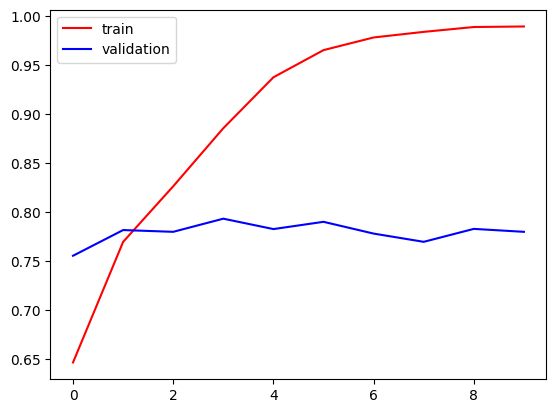

In [ ]:
# Graph before applying dropout and batch normalization
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.plot()

[]

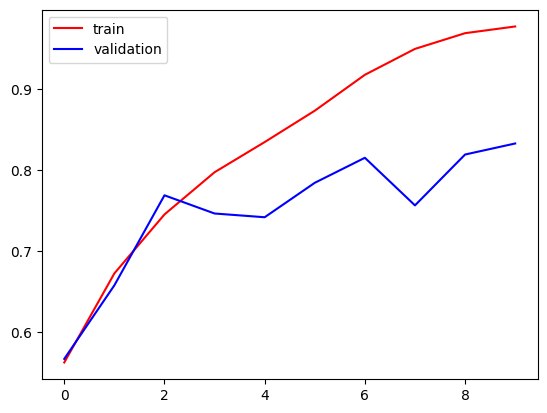

In [ ]:
# Graph after applying dropout and batch normalization
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.plot()

[]

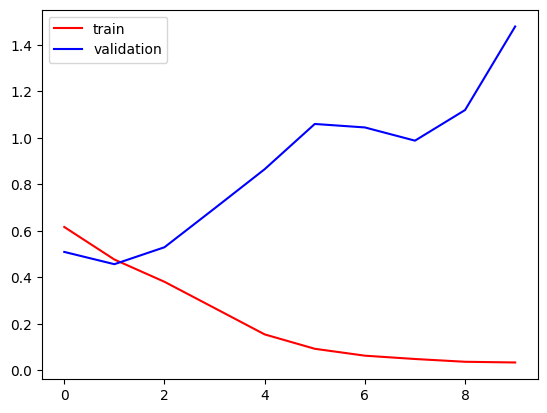

In [ ]:
# Graph before applying dropout and batch normalization
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.plot()

[]

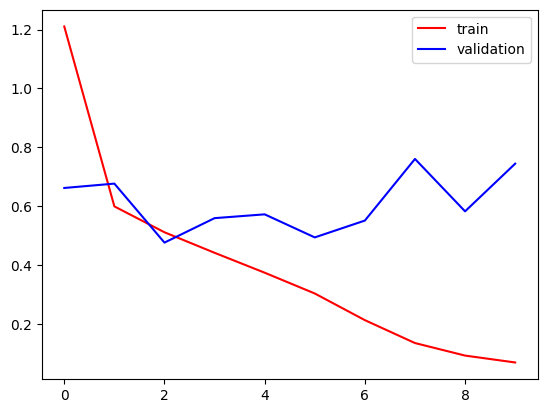

In [ ]:
# Graph after applying dropout and batch normalization
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.plot()

In [ ]:
import cv2

In [ ]:
test_img=cv2.imread('/content/Dog.jpg')

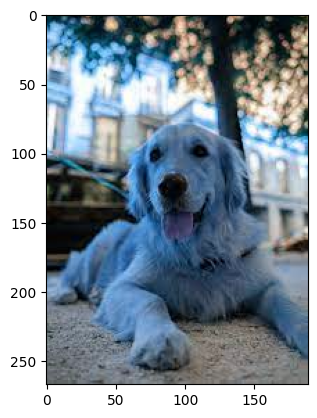

In [ ]:
plt.imshow(test_img)

In [ ]:
test_img.shape

(267, 189, 3)

In [ ]:
# Reshaping our image in (256x256)
test_img=cv2.resize(test_img,(256,256))

In [ ]:
test_input=test_img.reshape((1,256,256,3))  # (1,256,256,3)-> This means this batch contains 1 image of size (256,256,3)

In [ ]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([[1.]], dtype=float32)

In [ ]:
test2_img=cv2.imread('/content/Cat.jpg')

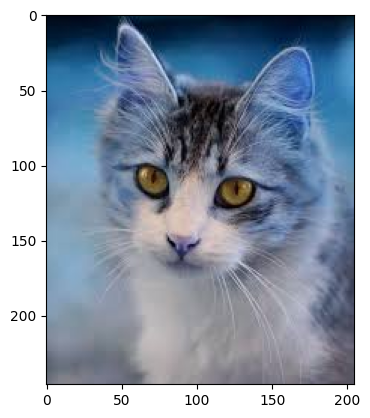

In [ ]:
plt.imshow(test2_img)

In [ ]:
test2_img.shape

(246, 205, 3)

In [ ]:
# Reshaping our image in (256x256)
test2_img=cv2.resize(test2_img,(256,256))

In [ ]:
test2_input=test2_img.reshape((1,256,256,3))  # (1,256,256,3)-> This means this batch contains 1 image of size (256,256,3)

In [ ]:
model.predict(test2_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


array([[0.]], dtype=float32)

In [ ]:
model.evaluate(validation_ds)

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.8391 - loss: 0.7179


[0.7446344494819641, 0.8325999975204468]

In [ ]:
model.evaluate(train_ds)

625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.9847 - loss: 0.0442


[0.03700951114296913, 0.98785001039505]